### Excess Return Models - (Rebonato 2018)

- Provides broad-level market insights on profitability of being long duration in nominal rates.
- Strategy
    - Long the n-year maturity bond
    - Fund the long position by being short the 1-year maturity bond
    - Unwind position after 1-year, record PnL

Reference : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3183653

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm

In [8]:
FIGSIZE = (8, 6)
XRET_KEY_RATES = [2, 5, 7, 10, 15, 20]

In [9]:
yields_data = pd.read_excel('feds200628.xlsx', sheet_name='Yields', skiprows=1, index_col='Date', parse_dates=True )
yields_data = yields_data.div(100.)
yields_data = yields_data.loc[:, [f'SVENY{x:02d}' for x in range(1, 31)] ]
cpi_data = pd.read_excel('CPILFENS.xls', skiprows=10)

In [124]:
def calc_persistent_cpi(cpi_data):
    v_arr = np.array(list(reversed([0.9868 ** i for i in range(120)])))
    v_sum = np.sum(v_arr)

    cpi_yoy = cpi_data.pct_change(periods=12).dropna()

    cpi_persistent = cpi_yoy.rolling(120).apply(lambda series: (series * v_arr).sum() / v_sum).dropna()
    # cpi_persistent = cpi_yoy.rolling(120).apply(f).dropna()
    cpi_persistent.rename(columns={'CPI': 'CPI_Persistent'}, inplace=True)
    
    return cpi_yoy, cpi_persistent

def calc_excess_return(yields_data):
    log_return = yields_data.apply(lambda x: -int(x.name.replace('SVENY', '')) * x)
    shifted_log_return = log_return.shift(-12).shift(axis=1)
    xret = (shifted_log_return - log_return).add(log_return['SVENY01'], axis='index')
    xret.drop(columns=['SVENY01'], inplace=True)
    xret.rename(inplace=True, columns=dict((k, v) for k, v in 
                                zip([f'SVENY{x:02d}' for x in range(2, 31)],
                                    [f'xret{x:02d}' for x in range(2, 31)])))
    xret['xret_avg'] = xret.loc[:, [f'xret{x:02d}' for x in XRET_KEY_RATES]].mean(axis=1)
    xret = xret[~xret.loc[:, [f'xret{x:02d}' for x in XRET_KEY_RATES]].isna().any(axis=1)]

    return xret

def prep_prediction_data(yields_data, cpi_data, start_date, end_date):
    
    # print(f'Using start date {start_date}')
    yields_os_data = yields_data.reindex(columns=[f'SVENY{x:02d}' for x in range(1, 31)])
    
    yields_os_data = yields_os_data.resample('M').last().dropna(axis=0, how='all')
    yields_os_data = yields_os_data.loc[start_date:end_date]

    cpi_os_data = cpi_data.set_index('observation_date')
    cpi_os_data = cpi_os_data.resample('M').last()
    _, cpi_os_data = calc_persistent_cpi(cpi_os_data)
    cpi_os_data = cpi_os_data.loc[start_date:end_date]
    return yields_os_data, cpi_os_data

In [120]:
class  RebonatoExcessReturnModel(object):
    
    def __init__(self, cpi_data, yields_data, start_date, end_date):

        # take a copy of the data
        cpi_data = cpi_data.copy()
        yields_data = yields_data.copy()
        cpi_data.set_index('observation_date', inplace=True)
        cpi_data.rename(columns={'CPILFENS':'CPI'}, inplace=True)
        cpi_data = cpi_data.resample('M').last()

        yields_data = yields_data.reindex(columns=[f'SVENY{x:02d}' for x in range(1, 31)])
        yields_data.sort_index(inplace=True)
        yields_data = yields_data.resample('M').last().dropna(axis=0, how='all')

        self.cpi_data = self.calc_persistent_cpi(cpi_data)
        self.yields_data = yields_data
        self.start_date, self.end_date = start_date, end_date

    def calc_persistent_cpi(self, cpi_data):
        cpi_yoy, cpi_persistent = calc_persistent_cpi(cpi_data)
        self.cpi_yoy = cpi_yoy
        self.cpi_persistent_rs = cpi_persistent

    def fit(self):
        self.calc_excess_return(self.yields_data)
        self.xret = self.xret.loc[self.start_date:self.end_date]
        yields_data = self.yields_data.loc[self.start_date:self.end_date]
        cpi = self.cpi_persistent_rs.loc[self.start_date:self.end_date]

        # cycle-trend decomposition
        # 1. lvl_t = average yield from 2 yrs onwards, slope_t = lvl_t - y1
        
        yield_lvl = yields_data.loc[:, [f'SVENY{x:02d}' for x in XRET_KEY_RATES] ].mean(axis=1)
        yield_slope = yield_lvl.subtract(yields_data.loc[:, 'SVENY01'])

        # 2. trend / cycle decompose conditioned on persistent CPI
        y = yield_lvl
        x = sm.add_constant(cpi)
        self.lvl_model = sm.OLS(y, x, missing='drop').fit()
        
        y = yield_slope
        self.slope_model = sm.OLS(y, x, missing='drop').fit()

        # 3. calculate lvl_cyc
        lvl_cycle = yield_lvl - self.lvl_model.fittedvalues

        y = self.xret['xret_avg'].loc[self.start_date:self.end_date]
        x = sm.add_constant(pd.concat([lvl_cycle, yield_slope], axis=1))

        self.nsf_model = sm.OLS(y, x, missing='drop').fit()

        self.fit_xr_model()

    def fit_xr_model(self):
        xr_model = {}

        x = self.nsf_model.fittedvalues
        x = sm.add_constant(x)
        for xr in XRET_KEY_RATES:
            y = self.xret[f'xret{xr:02d}']
            model = sm.OLS(y, x, missing='drop')
            res = model.fit()
            xr_model[xr] = res 

        self.xr_model = xr_model

    def predict(self, cpi, yields_data):

        yield_lvl = yields_data.loc[:, [f'SVENY{x:02d}' for x in XRET_KEY_RATES] ].mean(axis=1)
        yield_slope = yield_lvl.subtract(yields_data.loc[:, 'SVENY01'])
        lvl_cycle = yield_lvl - self.lvl_model.predict(sm.add_constant(cpi))
        nsf = self.nsf_model.predict(sm.add_constant(pd.concat([lvl_cycle, yield_slope], axis=1)))
        
        nsf = sm.add_constant(nsf)

        xret_predictions = {}  
        for xr in XRET_KEY_RATES:
            xret_predictions[f'pxret{xr:02d}'] = self.xr_model[xr].predict(nsf) 

        xret_df = pd.DataFrame(xret_predictions)
        return xret_df

    def calc_excess_return(self, yields_data):
        self.xret = calc_excess_return(yields_data)

    def plot_xret(self):
        data = self.xret.loc[:, [f'xret{x:02d}' for x in XRET_KEY_RATES] ]
        data.plot(figsize=FIGSIZE, title=f'Excess Returns for {XRET_KEY_RATES} yrs')

    def plot_cpi(self):
        cpi_data_full = pd.merge(self.cpi_yoy, self.cpi_persistent_rs, how='right', on='observation_date')
        cpi_data_full.plot(figsize=FIGSIZE)

    def plot_all_in_one(self, predicted_df, realized_xret, lw=2., ccy='USD'):
        ax = predicted_df.plot(figsize=FIGSIZE, style=dict((k, '--') for k in predicted_df.columns), 
                          title='Rebonato (2018) - Predicted (pxret) vs. Realized (rxret) Excess Return (%s)' % ccy, 
                          ylabel='Log Return', lw=lw)

        color_dict = dict( (l._label.replace('p', 'r'), f'{l.get_color()}' ) for l in ax.lines )
        rxret = realized_xret.loc[:,[f'rxret{x:02d}' for x in XRET_KEY_RATES]]
        _ = rxret.plot(figsize=(16, 8), ax=ax, color=color_dict, lw=lw)

    def plot_individual(self, predicted_df, realized_xret, lw=4.0, ccy='USD'):
        from itertools import chain
        fig, axes = plt.subplots(3, 2, figsize=(18,12), constrained_layout=True)
        
        axes = list(chain.from_iterable(axes))
        for idx, c in enumerate(predicted_df.columns):
            ax = axes[idx]
            ax.set_title('%s-Yr Excess Return (%s)' % (int(c.replace('pxret', '')), ccy))
            predicted_df.loc[:, c].plot(ax=ax, style='--', label='predicted', lw=lw)
            realized_xret.loc[:, c.replace('pxret', 'rxret')].plot(ax=ax, label='realized', lw=lw)
            ax.legend()
        
    def plot_predicted_vs_realized(self, predicted_df, yields_data, lw=2., all_in_one=True, ccy='USD'):
        
        realized_xret = calc_excess_return(yields_data)
        realized_xret.rename(inplace=True, columns=dict((k, v) for k, v in 
            zip(
                [f'xret{x:02d}' for x in XRET_KEY_RATES], 
                [f'rxret{x:02d}' for x in XRET_KEY_RATES]
                )
        ))

        if all_in_one:
            self.plot_all_in_one(predicted_df, realized_xret, ccy=ccy)
        else:
            self.plot_individual(predicted_df, realized_xret, ccy=ccy)


#### Model Training 

In [109]:
start_date, end_date = pd.Timestamp('1995-01-31'), pd.Timestamp('2019-10-31')
cpmodel = RebonatoExcessReturnModel(cpi_data, yields_data, start_date, end_date)
cpmodel.fit()

Model Prediction

In [110]:
os_start_date = end_date + MonthEnd(1)
os_end_date = pd.Timestamp('2022-03-31')
yields_os_data, cpi_os_data = prep_prediction_data(yields_data, cpi_data, os_start_date, os_end_date)

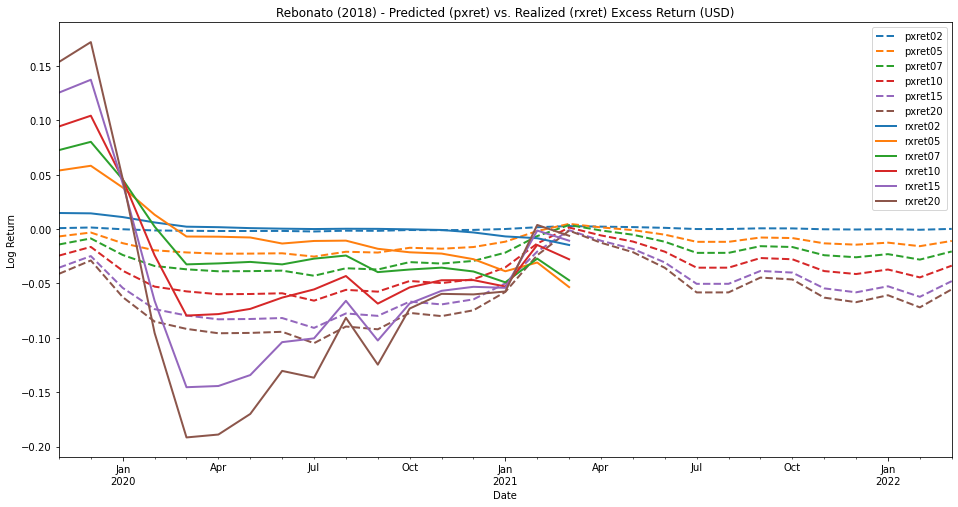

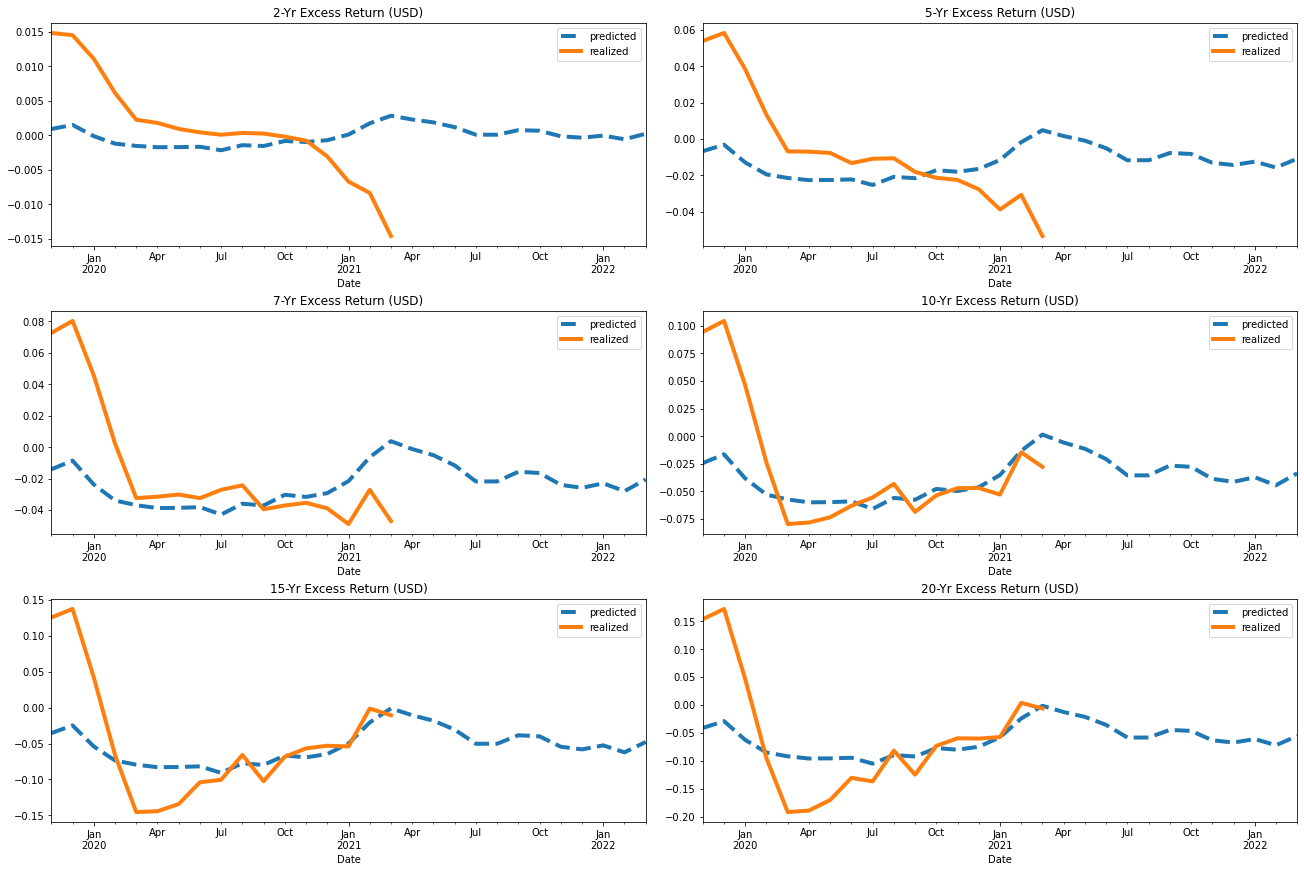

In [111]:
predicted_df = cpmodel.predict(cpi_os_data, yields_os_data)
cpmodel.plot_predicted_vs_realized(predicted_df, yields_os_data)
cpmodel.plot_predicted_vs_realized(predicted_df, yields_os_data, all_in_one=False)

#### GBP Predictions (UK)

We use the USD model to predict UK excess returns

In [121]:
UK_cpi_data = pd.read_excel('UK_inflation.xlsx', parse_dates=['Date'] )
UK_cpi_data.rename(columns={'DKC6':'CPI', 'Date':'observation_date'}, inplace=True)
# UK_cpi_yoy, UK_cpi_persistent = calc_persistent_cpi(UK_cpi_data)
# pd.merge(UK_cpi_yoy, UK_cpi_persistent, left_index=True, right_index=True).plot()
UK_cpi_data

,observation_date,CPI
0,1988-01-01,52.9
1,1988-02-01,53.1
2,1988-03-01,53.4
3,1988-04-01,54.0
4,1988-05-01,54.3
...,...,...
406,2021-11-01,114.2
407,2021-12-01,114.8
408,2022-01-01,114.4
409,2022-02-01,115.3


In [126]:
UK_yields_data1 = pd.read_excel('UK_data1.xlsx', sheet_name='4. spot curve', skiprows=3, parse_dates=True )
UK_yields_data2 = pd.read_excel('UK_data2.xlsx', sheet_name='4. spot curve', skiprows=3, parse_dates=True )
UK_yields_data = pd.concat([UK_yields_data1, UK_yields_data2], axis=0).dropna(how='all')
name_dict = dict(zip(range(1, 31), [ f'SVENY{x:02d}' for x in range(1, 31)]))
name_dict['years:'] = 'Date'
UK_yields_data.rename(columns=name_dict, inplace=True)
UK_yields_data['Date'] = pd.to_datetime(UK_yields_data['Date'])
UK_yields_data = UK_yields_data.loc[:, ['Date'] + [ f'SVENY{x:02d}' for x in range(1, 31)]]
UK_yields_data.set_index('Date', inplace=True)
UK_yields_data = UK_yields_data.div(100.)

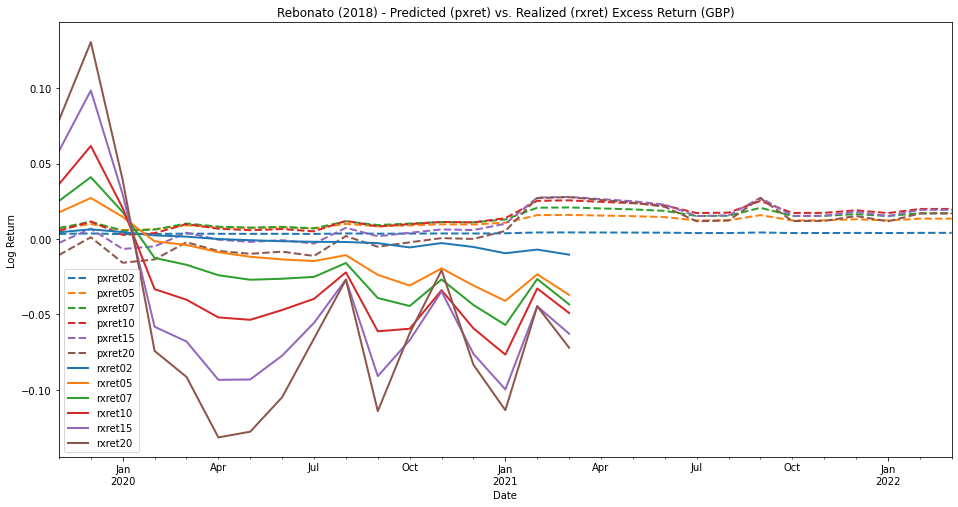

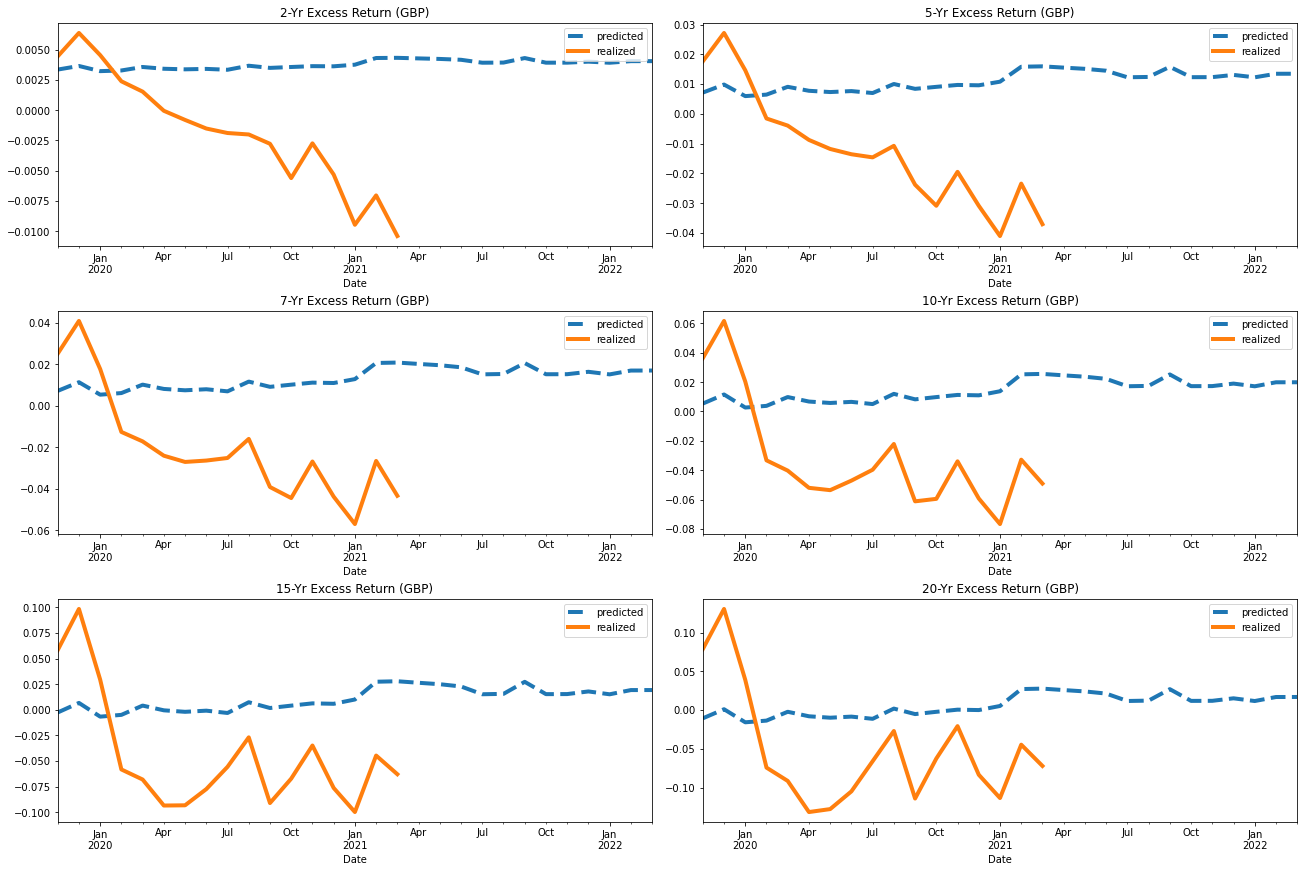

In [127]:
start_date, end_date = pd.Timestamp('1999-01-31'), pd.Timestamp('2019-10-31')
ukmodel = RebonatoExcessReturnModel(UK_cpi_data, UK_yields_data, start_date, end_date)
ukmodel.fit()
UK_yields_os_data, cpi_os_data = prep_prediction_data(UK_yields_data, UK_cpi_data, os_start_date, os_end_date)
predicted_df = ukmodel.predict(cpi_os_data, UK_yields_os_data)
cpmodel.plot_predicted_vs_realized(predicted_df, UK_yields_os_data, ccy='GBP')
cpmodel.plot_predicted_vs_realized(predicted_df, UK_yields_os_data, all_in_one=False, ccy='GBP')

### Appendix

##### I - CPI and Persistent Component

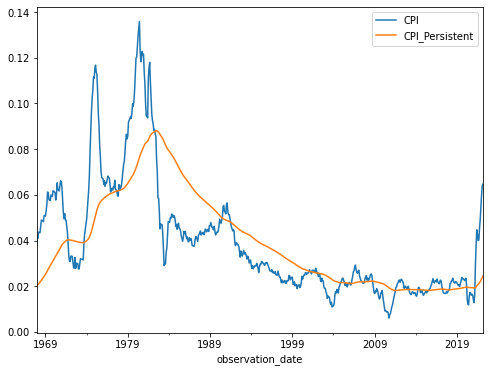

In [ ]:
cpmodel.plot_cpi()

##### (II) - Excess Returns for various tenors

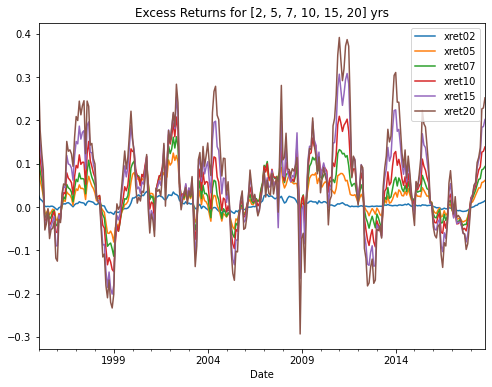

In [ ]:
cpmodel.plot_xret()